In [1]:
%cd ..

/home/sheik_dawood/Workspace/compoundGAN


In [2]:
import torch
import networkx as nx
from rdkit import Chem
from rdkit.Chem import Draw

from data.zinc import mol2graph, Library

from models.encoder import Encoder
from models.generator import Generator

from matplotlib import pyplot as plt
%matplotlib inline

In [115]:
state_dict = torch.load('/storage/sheik_dawood/Experiments/compoundGAN/compound-gan-a8fcf45856154d729ec334d81906580d/model_3.weights')

In [128]:
enc = Encoder(59, 13, 256)
enc = enc.cuda()
enc.load_state_dict(state_dict['enc_state_dict'])
enc = enc.eval()

gen = Generator(256, [44, 7, 3, 3, 2], [5, 2, 2, 4])
gen = gen.cuda()
gen.load_state_dict(state_dict['gen_state_dict'])
gen = gen.eval()

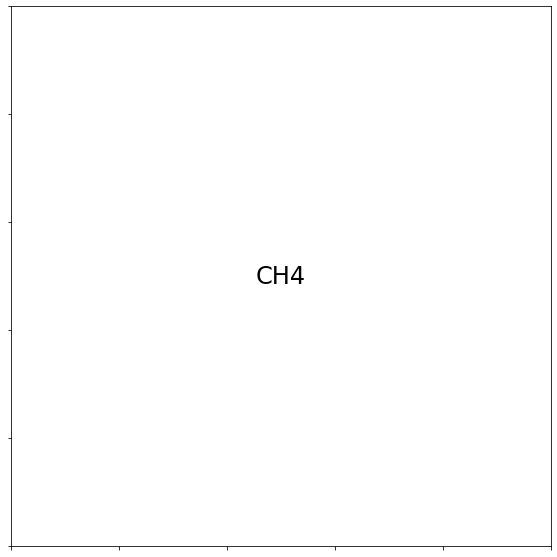

In [150]:
#smiles = 'C1=CC=CC=C1'
smiles = 'C'
#smiles = 'CCOc1ccc(OCC)c([C@H]2C(C#N)=C(N)N(c3ccccc3C(F)(F)F)C3=C2C(=O)CCC3)c1'
mol = Chem.MolFromSmiles(smiles)
Draw.MolToMPL(mol); plt.show()

In [151]:
G, atom_feats, bond_feats = mol2graph(mol)
G.to(torch.device('cuda:0'))
mu, var = enc(G)

In [154]:
z = enc.reparameterize(mu, var, no_noise=True)
node_list, edge_list = gen(z.unsqueeze(0), 100)
nodes = []
edges = []
for i, node in enumerate(node_list):
    n = []
    print(Library.atom_list[node[0][0].data.cpu().numpy()[0]], node[0][1].data.cpu().item())
    n.append(Library.atom_list[node[0][0].data.cpu().numpy()[0]])
    n.append(Library.charge_list[node[1][0].data.cpu().numpy()[0]])
    n.append(Library.electron_list[node[2][0].data.cpu().numpy()[0]])
    try:
        n.append(Library.chirality_list[node[3][0].data.cpu().numpy()[0]])
    except IndexError:
        n.append('')
    nodes.append(n[0])
    
    e = []
    _edges = edge_list[i]
    for j, edge in enumerate(_edges):
        print(edge[0][1].data.cpu().item())
        idx = edge[0][0].data.cpu().numpy()[0]
        if idx == 0:
            continue
        e.append((idx, j))
        edges.append((j, i))

C 1.0
O 0.9626443386077881
0.9999384880065918
0.9211023449897766
H 0.9999996423721313
0.9999682903289795
0.9749481678009033
0.9984682202339172
H 0.993723452091217
0.9995088577270508
0.7801901698112488
0.9996381998062134
0.9999979734420776
H 0.9943408966064453
0.9914235472679138
0.8187702298164368
0.9968020915985107
0.9993526339530945
0.9982326030731201


In [155]:
edge_list

[[],
 [[(tensor([1], device='cuda:0'),
    tensor([0.9999], device='cuda:0', grad_fn=<MaxBackward0>)),
   (tensor([0], device='cuda:0'),
    tensor([1.], device='cuda:0', grad_fn=<MaxBackward0>)),
   (tensor([0], device='cuda:0'),
    tensor([1.0000], device='cuda:0', grad_fn=<MaxBackward0>)),
   (tensor([0], device='cuda:0'),
    tensor([1.], device='cuda:0', grad_fn=<MaxBackward0>))],
  [(tensor([1], device='cuda:0'),
    tensor([0.9211], device='cuda:0', grad_fn=<MaxBackward0>)),
   (tensor([0], device='cuda:0'),
    tensor([0.9994], device='cuda:0', grad_fn=<MaxBackward0>)),
   (tensor([0], device='cuda:0'),
    tensor([1.0000], device='cuda:0', grad_fn=<MaxBackward0>)),
   (tensor([0], device='cuda:0'),
    tensor([1.], device='cuda:0', grad_fn=<MaxBackward0>))]],
 [[(tensor([1], device='cuda:0'),
    tensor([1.0000], device='cuda:0', grad_fn=<MaxBackward0>)),
   (tensor([0], device='cuda:0'),
    tensor([1.0000], device='cuda:0', grad_fn=<MaxBackward0>)),
   (tensor([0], device='

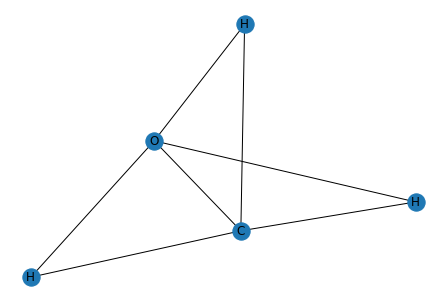

In [153]:
predicted = nx.Graph()
for i, n in enumerate(nodes):
    predicted.add_node(i, atom=n)
for e in edges:
    predicted.add_edge(*e)
    
for i, n in enumerate(nodes):
    continue
    if n == 'H':
        predicted.remove_node(i)
    
plt.figure()
#pos = nx.spring_layout(predicted)
pos = nx.kamada_kawai_layout(predicted)
nx.draw(predicted, pos)
node_labels = nx.get_node_attributes(predicted,'atom')
nx.draw_networkx_labels(predicted, pos, labels=node_labels)
plt.show()